In [1]:
# First cell - Imports and Setup
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import gc
import json
import zipfile
from sklearn.model_selection import train_test_split, KFold
from torch.utils.data import Dataset, DataLoader
from transformers import FlavaProcessor, FlavaModel, get_cosine_schedule_with_warmup, set_seed
from transformers import CLIPProcessor, CLIPModel
from torch import nn
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import random
import torchvision.transforms as transforms
from torch.cuda.amp import autocast, GradScaler
warnings.filterwarnings('ignore')

In [2]:
# Configure PyTorch memory allocation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:32'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Using device: cuda
GPU Memory Available: 15.83 GB


In [3]:
# Data Augmentation
class DataAugmentation:
    def __init__(self, p=0.5):
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=p),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0))
        ])

    def __call__(self, image):
        return self.transform(image)

In [4]:
class SarcasmDataset(Dataset):
    def __init__(self, df, processor, image_dir, max_length=77, augment=False):
        """
        A PyTorch dataset for sarcasm detection combining text and image modalities.

        Args:
            df (pd.DataFrame): The DataFrame containing dataset information.
            processor: Processor to handle text and image inputs.
            image_dir (str): Directory containing image files.
            max_length (int, optional): Maximum token length for text inputs. Defaults to 77.
            augment (bool, optional): Whether to apply image augmentations. Defaults to False.
        """
        self.df = df
        self.processor = processor
        self.image_dir = image_dir
        self.max_length = max_length
        self.augment = augment
        self.transform = DataAugmentation() if self.augment else None

    def __len__(self):
        return len(self.df)

    def prepare_text(self, row):
        """
        Prepare the combined text input from caption, description, and OCR text.
        """
        text_fields = [
            str(row['caption']) if pd.notna(row['caption']) else '',
            str(row['description']) if pd.notna(row['description']) else '',
            str(row['text_ocr']) if pd.notna(row['text_ocr']) else ''
        ]
        return ' '.join([field for field in text_fields if field])

    def load_image(self, image_path):
        """
        Load and process an image.
        """
        if not os.path.isfile(image_path):
            raise FileNotFoundError(f"Image file not found: {image_path}")

        try:
            with Image.open(image_path) as img:
                image = img.convert('RGB')
        except Exception as e:
            raise RuntimeError(f"Failed to open or process image at {image_path}: {e}")

        # Apply transformations if available
        if self.transform:
            try:
                image = self.transform(image)
            except Exception as e:
                raise RuntimeError(f"Error during image transformation at {image_path}: {e}")

        return image

    def __getitem__(self, idx):
        """
        Retrieve an item by index.
        """
        try:
            row = self.df.iloc[idx]
            text = self.prepare_text(row)
            image_path = os.path.join(self.image_dir, row['image'])
            image = self.load_image(image_path)

            # Process text and image
            encoding = self.processor(
                text=text,
                images=image,
                return_tensors="pt",
                padding='max_length',
                truncation=True,
                max_length=self.max_length
            )

            # Squeeze tensors and add labels
            encoding = {k: v.squeeze() for k, v in encoding.items()}
            encoding['labels'] = torch.tensor(row['label'], dtype=torch.long)

            return encoding
        except Exception as e:
            logging.error(f"Error processing index {idx}: {e}")
            raise e


In [5]:
def collate_fn(batch):
    batch = [item for item in batch if item is not None]  # Filter out None entries
    if len(batch) == 0:
        return None  # Return None if batch is empty after filtering

    try:
        collated = {}
        for key in batch[0]:
            if key == 'labels':
                collated[key] = torch.tensor([item[key] for item in batch])
            else:
                collated[key] = torch.stack([item[key] for item in batch], dim=0)
        return collated
    except Exception as e:
        print(f"Error in collate_fn: {e}")
        return None

In [6]:
class MultimodalSarcasmClassifier(nn.Module):
    def __init__(self, num_labels=2):
        super().__init__()
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
        # self.clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        
        for param in self.clip.parameters():
            param.requires_grad = False

        self.hidden_size = self.clip.config.projection_dim
        self.classifier = nn.Sequential(
            nn.LayerNorm(self.hidden_size * 2),
            nn.Linear(self.hidden_size * 2, 1080),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(1080, 512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_labels)
        )

    def forward(self, input_ids, pixel_values, attention_mask=None):
        outputs = self.clip(
            input_ids=input_ids,
            pixel_values=pixel_values,
            attention_mask=attention_mask,
            return_dict=True
        )

        text_features = outputs.text_embeds
        image_features = outputs.image_embeds
        combined_features = torch.cat((text_features, image_features), dim=1)

        logits = self.classifier(combined_features)
        probabilities = nn.functional.softmax(logits, dim=1)
        return probabilities

In [7]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return False

In [8]:
# Training and Validation Functions
def train_epoch(model, dataloader, optimizer, scheduler, criterion, device, scaler):
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []
    progress_bar = tqdm(dataloader, desc='Training')

    for batch in progress_bar:
        try:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            with autocast():
                outputs = model(input_ids, pixel_values, attention_mask)
                loss = criterion(outputs, labels)
                
            # Backward pass
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if scheduler:
                scheduler.step()
            # Collect metrics
            total_loss += loss.item()
            predictions.extend(outputs.argmax(dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            # Update progress bar
            progress_bar.set_postfix({'loss': loss.item()})

        except Exception as e:
            print(f"Error in batch: {str(e)}")
            continue

    predictions, true_labels = np.array(predictions), np.array(true_labels)
    cm = confusion_matrix(true_labels, predictions)
    metrics = {
        'loss': total_loss / len(dataloader),
        'accuracy': accuracy_score(true_labels, predictions),
        'f1_score': f1_score(true_labels, predictions, average='weighted'),
        'precision': precision_score(true_labels, predictions, average='weighted'),
        'recall': recall_score(true_labels, predictions, average='weighted'),
        'confusion_matrix': cm
    }

    return metrics


In [9]:
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probabilities = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating"):
            input_ids = batch['input_ids'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

    
            outputs = model(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask)
            probabilities = torch.softmax(outputs, dim=1)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            all_preds.extend(outputs.argmax(-1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    metrics = {
        'loss': total_loss / len(dataloader),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'probabilities': all_probabilities,
        'labels': all_labels
    }
    
    return metrics

def print_metrics(phase, metrics):
    print(f"\n{phase} Metrics:")
    print(f"Loss: {metrics['loss']:.4f}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"F1-Score: {metrics['f1_score']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    # Thêm try-except để xử lý trường hợp không có confusion matrix
    try:
        plt.figure(figsize=(8, 6))
        sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
        plt.title(f'{phase} Confusion Matrix')  # Thêm phase vào title
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    except KeyError:
        print("Warning: Confusion matrix not found in metrics")

In [12]:
def cross_validation_train(df, image_dir, 
                           n_splits=3, 
                           test_size=0.15, batch_size=8, epochs=3, learning_rate=2e-5):
    set_seed(42)
    
    # Đầu tiên, tách ra tập test
    train_val_df, test_df = train_test_split(df, test_size=test_size, random_state=42, stratify=df['label'])
    
    # Sau đó thực hiện k-fold trên phần train_val
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

    fold_results = []
    all_val_labels = [] 
    
    # Tạo test dataset và dataloader một lần
    test_dataset = SarcasmDataset(test_df, processor, image_dir, augment=False)
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True
    )

    for fold, (train_idx, val_idx) in enumerate(kfold.split(train_val_df)):
        print(f"\nTraining Fold {fold + 1}/{n_splits}")

        train_data = train_val_df.iloc[train_idx].reset_index(drop=True)
        val_data = train_val_df.iloc[val_idx].reset_index(drop=True)
        all_val_labels.append(val_data['label'].values) # Lưu nhãn của tập validation

        # Create datasets
        train_dataset = SarcasmDataset(train_data, processor, image_dir, augment=True)
        val_dataset = SarcasmDataset(val_data, processor, image_dir, augment=False)

        # Create dataloaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
            collate_fn=collate_fn
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            num_workers=4,
            pin_memory=True,
            collate_fn=collate_fn
        )

        # Initialize model and training components
        model = MultimodalSarcasmClassifier()
        model = model.to(device)

        # Calculate class weights from training data
        class_counts = train_data['label'].value_counts()
        class_weights = torch.FloatTensor([1.0 / (class_counts[i] / len(train_data)) for i in range(len(class_counts))])
        criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=0.01
        )

        num_training_steps = len(train_loader) * epochs
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=100,
            num_training_steps=num_training_steps
        )

        scaler = GradScaler()
        early_stopping = EarlyStopping(patience=3, min_delta=0.001)

        best_val_f1 = 0
        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs}")

            train_metrics = train_epoch(model, train_loader, optimizer, scheduler, criterion, device, scaler)
            print_metrics("Training", train_metrics)

            val_metrics = validate(model, val_loader, criterion, device)
            print_metrics("Validation", val_metrics)

            if val_metrics['f1_score'] > best_val_f1:
                best_val_f1 = val_metrics['f1_score']
                torch.save({
                    'fold': fold,
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'metrics': val_metrics,
                    'probabilities': val_metrics['probabilities'],
                    'val_labels': val_metrics['labels']
                }, f'CLIP_fold_{fold}.pt')

            if early_stopping(val_metrics['loss']):
                print("Early stopping triggered")
                break

        # Load best model for this fold and evaluate on both validation and test sets
        checkpoint = torch.load(f'CLIP_fold_{fold}.pt')
        model.load_state_dict(checkpoint['model_state_dict'])
        
        final_val_metrics = validate(model, val_loader, criterion, device)
        test_metrics = validate(model, test_loader, criterion, device)

        fold_results.append({
            'fold': fold,
            'val_metrics': final_val_metrics,
            'test_metrics': test_metrics
        })

        # Clear memory
        del model, optimizer, scheduler, train_loader, val_loader
        torch.cuda.empty_cache()
        gc.collect()

    # Print average results across folds
    print("\nCross-validation Results:")
    
    # Calculate average validation metrics
    avg_val_metrics = {
        'accuracy': np.mean([r['val_metrics']['accuracy'] for r in fold_results]),
        'f1_score': np.mean([r['val_metrics']['f1_score'] for r in fold_results]),
        'precision': np.mean([r['val_metrics']['precision'] for r in fold_results]),
        'recall': np.mean([r['val_metrics']['recall'] for r in fold_results])
    }
    
    # Calculate average test metrics
    avg_test_metrics = {
        'accuracy': np.mean([r['test_metrics']['accuracy'] for r in fold_results]),
        'f1_score': np.mean([r['test_metrics']['f1_score'] for r in fold_results]),
        'precision': np.mean([r['test_metrics']['precision'] for r in fold_results]),
        'recall': np.mean([r['test_metrics']['recall'] for r in fold_results])
    }

    print("\nValidation Metrics:")
    print(f"Average Accuracy: {avg_val_metrics['accuracy']:.4f}")
    print(f"Average F1-Score: {avg_val_metrics['f1_score']:.4f}")
    print(f"Average Precision: {avg_val_metrics['precision']:.4f}")
    print(f"Average Recall: {avg_val_metrics['recall']:.4f}")
    
    print("\nTest Metrics:")
    print(f"Average Accuracy: {avg_test_metrics['accuracy']:.4f}")
    print(f"Average F1-Score: {avg_test_metrics['f1_score']:.4f}")
    print(f"Average Precision: {avg_test_metrics['precision']:.4f}")
    print(f"Average Recall: {avg_test_metrics['recall']:.4f}")

    return fold_results, avg_val_metrics, avg_test_metrics

Total samples: 10805

Training Fold 1/3


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]


Epoch 1/3


Training: 100%|██████████| 766/766 [02:00<00:00,  6.35it/s, loss=0.653]



Training Metrics:
Loss: 0.6221
Accuracy: 0.6717
F1-Score: 0.6731
Precision: 0.6859
Recall: 0.6717


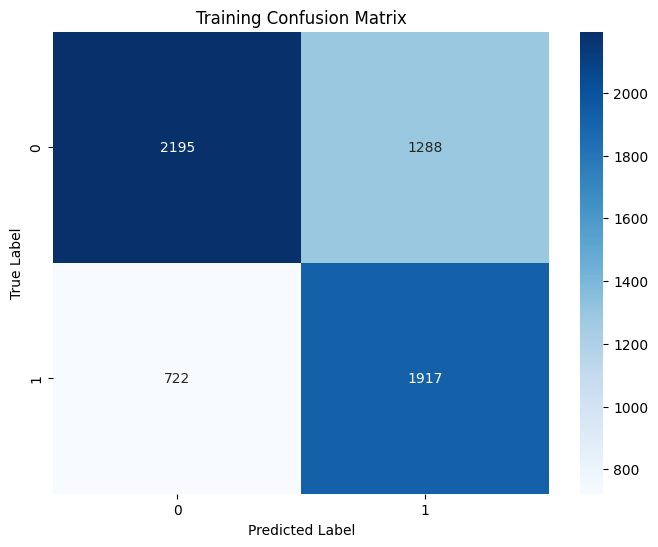

Validating: 100%|██████████| 383/383 [03:21<00:00,  1.90it/s]



Validation Metrics:
Loss: 0.5824
Accuracy: 0.7061
F1-Score: 0.7068
Precision: 0.7251
Recall: 0.7061


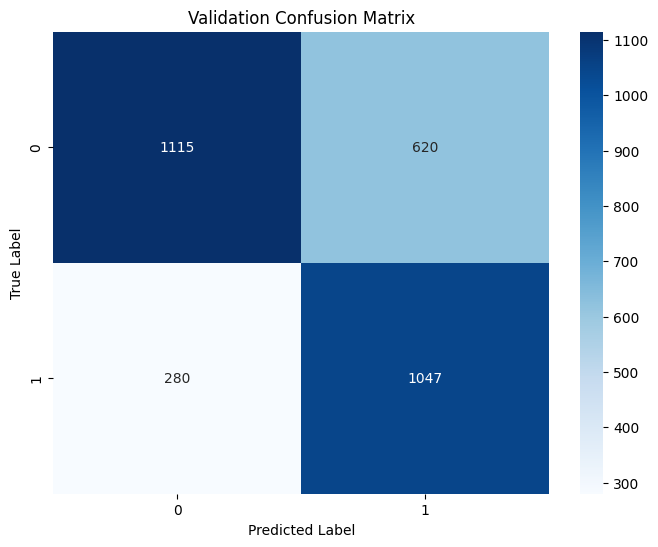


Epoch 2/3


Training: 100%|██████████| 766/766 [01:56<00:00,  6.57it/s, loss=0.711]



Training Metrics:
Loss: 0.5783
Accuracy: 0.7195
F1-Score: 0.7207
Precision: 0.7337
Recall: 0.7195


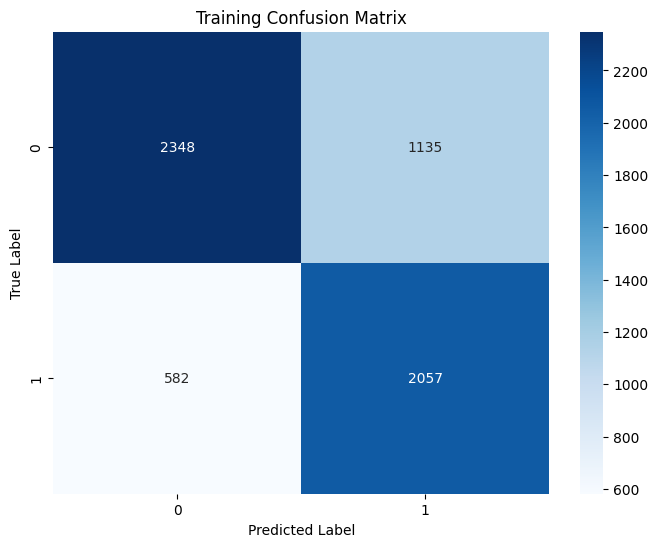

Validating: 100%|██████████| 383/383 [03:21<00:00,  1.90it/s]



Validation Metrics:
Loss: 0.5768
Accuracy: 0.7077
F1-Score: 0.7081
Precision: 0.7296
Recall: 0.7077


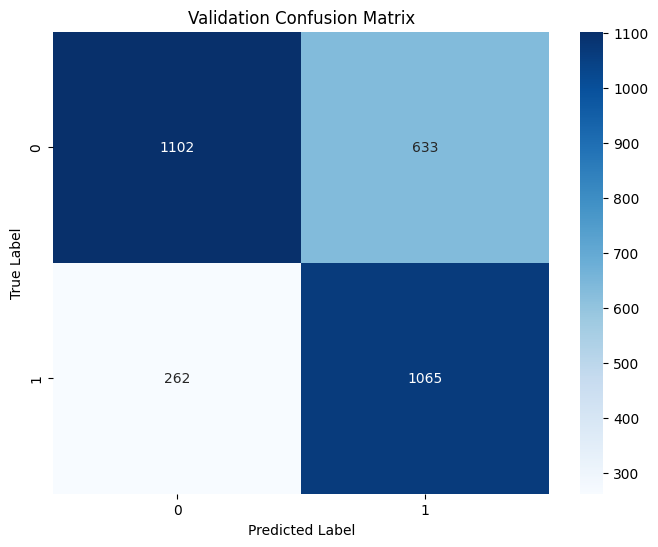


Epoch 3/3


Training: 100%|██████████| 766/766 [01:56<00:00,  6.58it/s, loss=0.884]



Training Metrics:
Loss: 0.5705
Accuracy: 0.7288
F1-Score: 0.7301
Precision: 0.7413
Recall: 0.7288


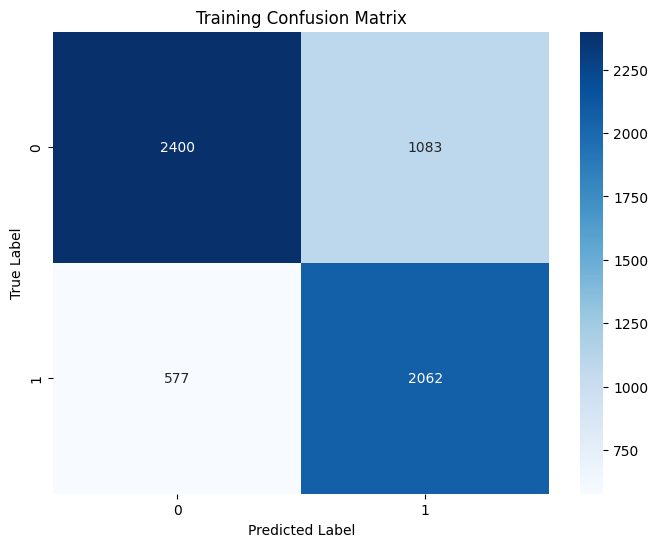

Validating: 100%|██████████| 383/383 [03:22<00:00,  1.90it/s]



Validation Metrics:
Loss: 0.5767
Accuracy: 0.7038
F1-Score: 0.7038
Precision: 0.7293
Recall: 0.7038


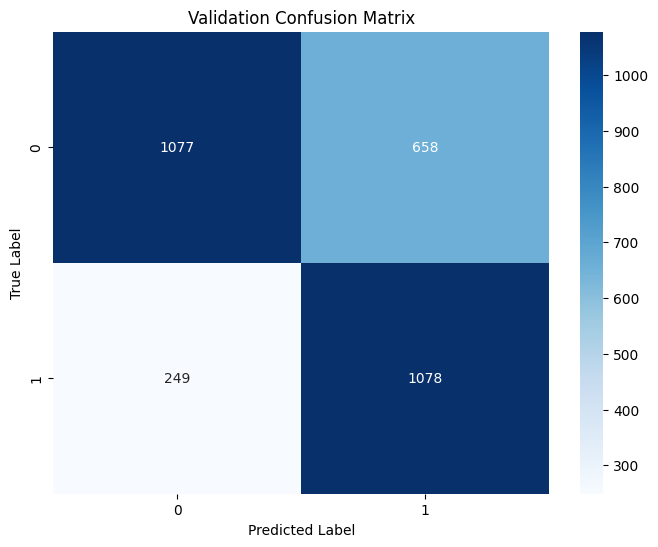

Validating: 100%|██████████| 203/203 [01:46<00:00,  1.90it/s]



Training Fold 2/3

Epoch 1/3


Training: 100%|██████████| 766/766 [01:56<00:00,  6.59it/s, loss=0.7]  



Training Metrics:
Loss: 0.6158
Accuracy: 0.6742
F1-Score: 0.6754
Precision: 0.6908
Recall: 0.6742


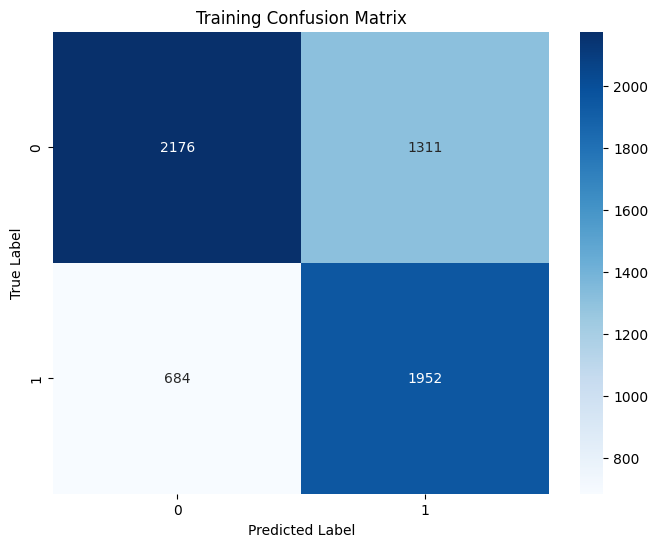

Validating: 100%|██████████| 383/383 [03:21<00:00,  1.90it/s]



Validation Metrics:
Loss: 0.5898
Accuracy: 0.6991
F1-Score: 0.7000
Precision: 0.7158
Recall: 0.6991


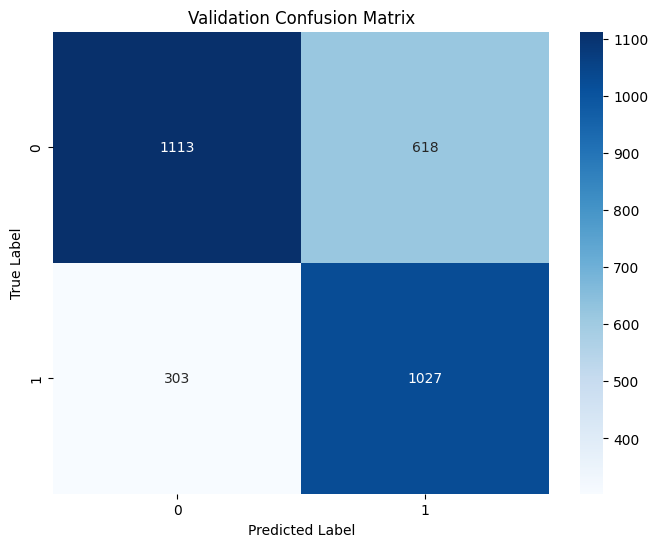


Epoch 2/3


Training: 100%|██████████| 766/766 [01:56<00:00,  6.58it/s, loss=0.546]



Training Metrics:
Loss: 0.5776
Accuracy: 0.7173
F1-Score: 0.7185
Precision: 0.7327
Recall: 0.7173


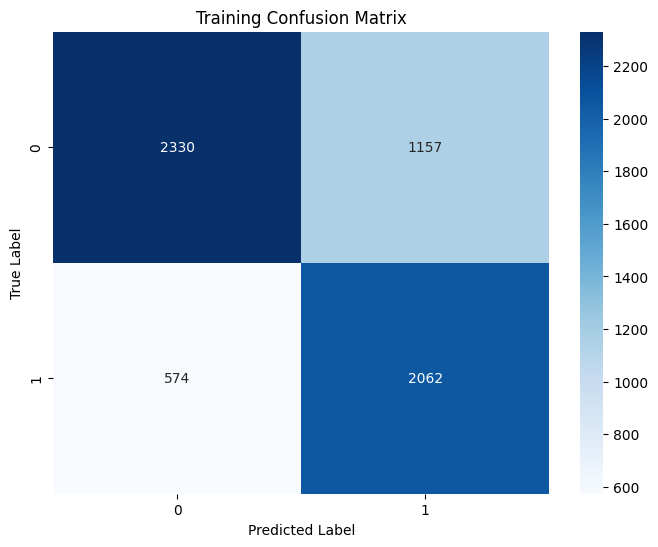

Validating: 100%|██████████| 383/383 [03:21<00:00,  1.90it/s]



Validation Metrics:
Loss: 0.5832
Accuracy: 0.7066
F1-Score: 0.7076
Precision: 0.7215
Recall: 0.7066


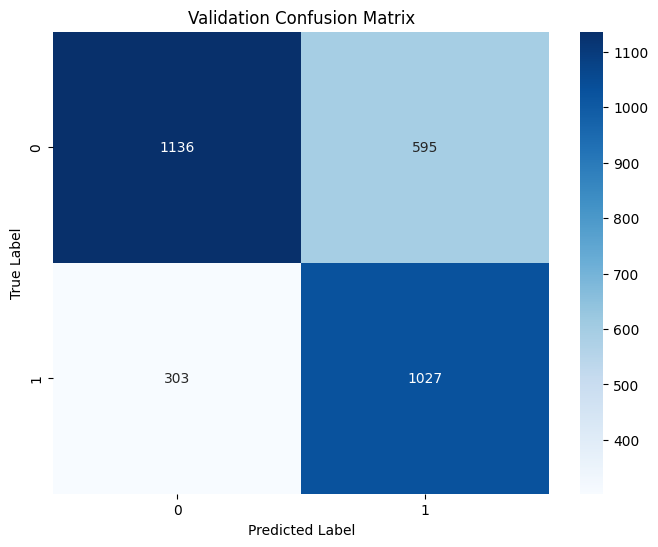


Epoch 3/3


Training: 100%|██████████| 766/766 [01:56<00:00,  6.57it/s, loss=0.36] 



Training Metrics:
Loss: 0.5659
Accuracy: 0.7295
F1-Score: 0.7307
Precision: 0.7437
Recall: 0.7295


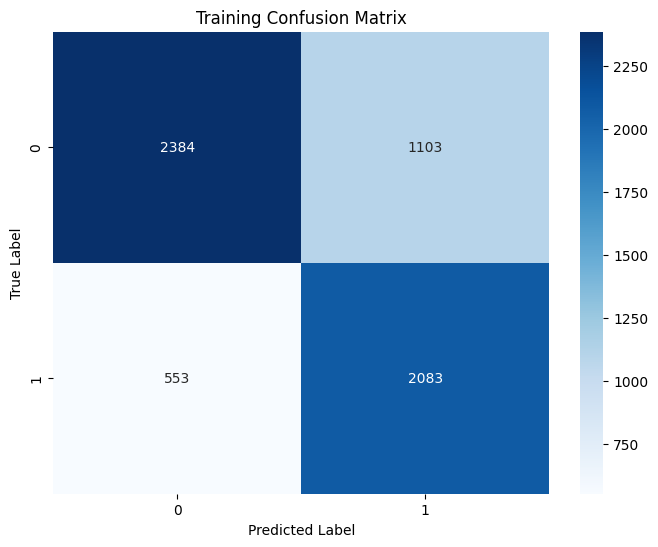

Validating: 100%|██████████| 383/383 [03:22<00:00,  1.90it/s]



Validation Metrics:
Loss: 0.5826
Accuracy: 0.7063
F1-Score: 0.7069
Precision: 0.7253
Recall: 0.7063


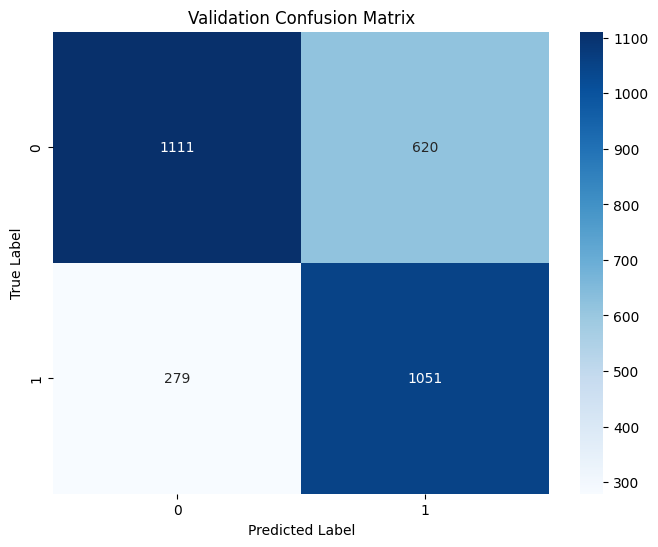

Validating: 100%|██████████| 203/203 [01:47<00:00,  1.89it/s]



Training Fold 3/3

Epoch 1/3


Training: 100%|██████████| 766/766 [01:56<00:00,  6.57it/s, loss=0.358]



Training Metrics:
Loss: 0.6236
Accuracy: 0.6709
F1-Score: 0.6717
Precision: 0.6889
Recall: 0.6709


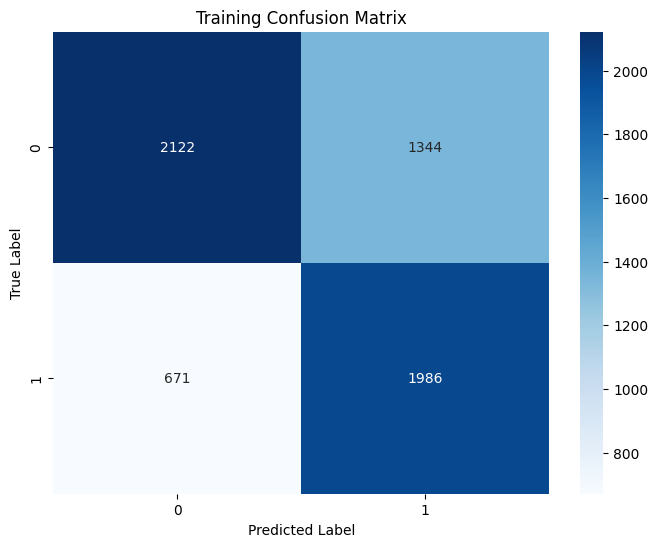

Validating: 100%|██████████| 383/383 [03:21<00:00,  1.90it/s]



Validation Metrics:
Loss: 0.5782
Accuracy: 0.7151
F1-Score: 0.7165
Precision: 0.7307
Recall: 0.7151


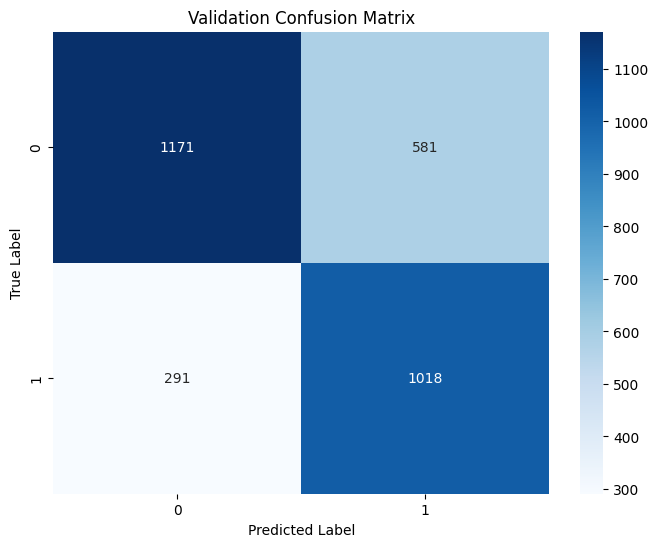


Epoch 2/3


Training: 100%|██████████| 766/766 [01:57<00:00,  6.52it/s, loss=0.69] 



Training Metrics:
Loss: 0.5810
Accuracy: 0.7152
F1-Score: 0.7163
Precision: 0.7272
Recall: 0.7152


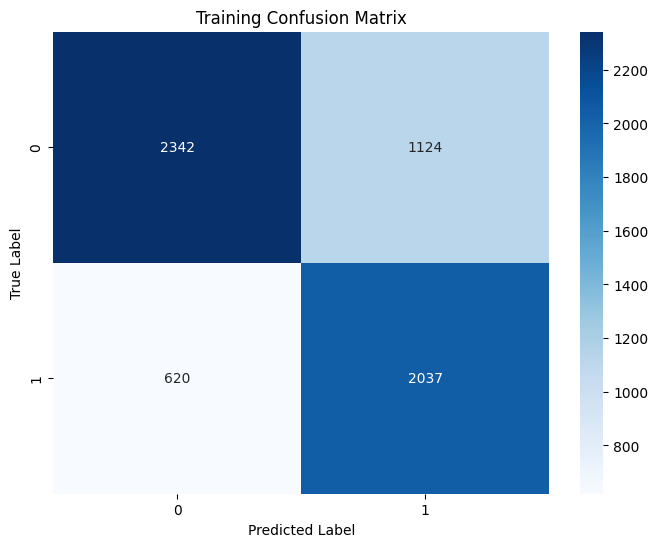

Validating: 100%|██████████| 383/383 [03:22<00:00,  1.89it/s]



Validation Metrics:
Loss: 0.5725
Accuracy: 0.7204
F1-Score: 0.7216
Precision: 0.7380
Recall: 0.7204


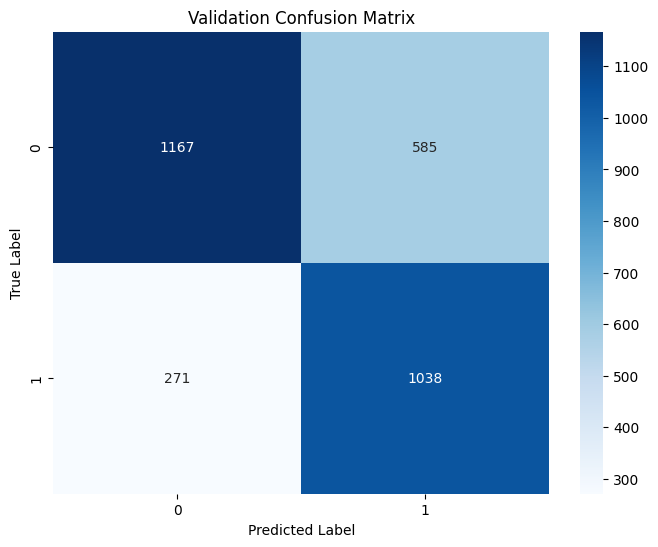


Epoch 3/3


Training: 100%|██████████| 766/766 [01:57<00:00,  6.55it/s, loss=0.776]



Training Metrics:
Loss: 0.5741
Accuracy: 0.7237
F1-Score: 0.7248
Precision: 0.7355
Recall: 0.7237


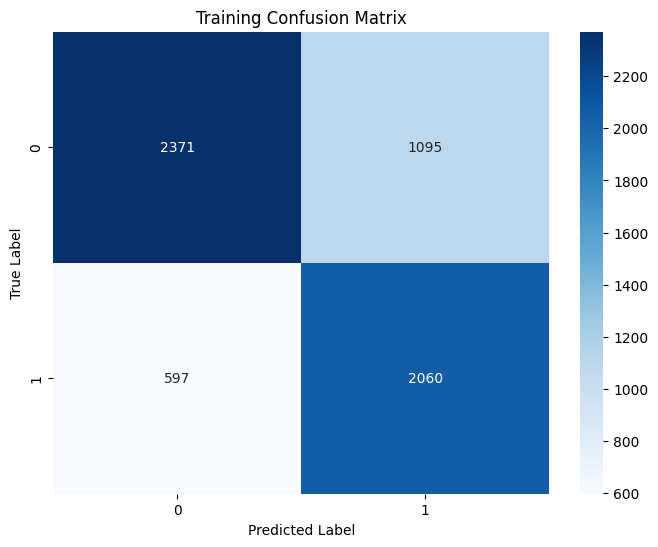

Validating: 100%|██████████| 383/383 [03:21<00:00,  1.90it/s]



Validation Metrics:
Loss: 0.5719
Accuracy: 0.7200
F1-Score: 0.7213
Precision: 0.7365
Recall: 0.7200


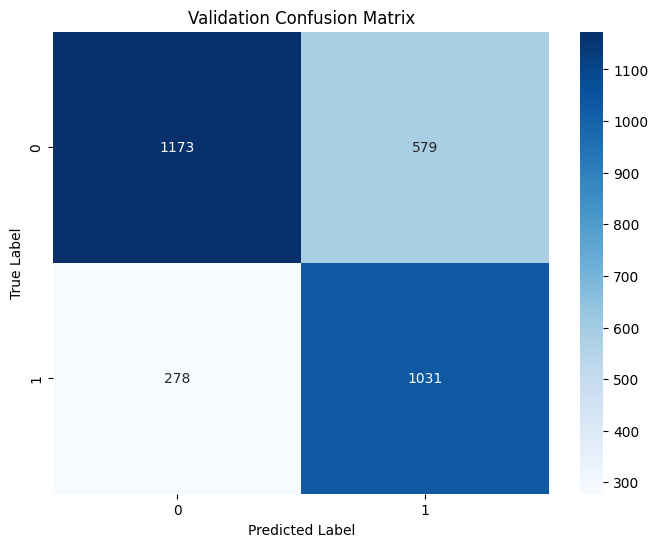

Validating: 100%|██████████| 203/203 [01:46<00:00,  1.90it/s]



Cross-validation Results:

Validation Metrics:
Average Accuracy: 0.7116
Average F1-Score: 0.7124
Average Precision: 0.7297
Average Recall: 0.7116

Test Metrics:
Average Accuracy: 0.7125
Average F1-Score: 0.7137
Average Precision: 0.7273
Average Recall: 0.7125

Training completed!
Final Test Metrics:
Accuracy: 0.7125
F1-Score: 0.7137
Precision: 0.7273
Recall: 0.7125


In [13]:
# Run Training
if __name__ == "__main__":
    IMAGE_DIR = "/kaggle/input/vimmsd-uit/UIT/IT/datasets/input/train/training-images/train-images/"
    df = pd.read_csv('/kaggle/input/approach2/image_data.csv')
    print("Total samples:", len(df))
    set_seed(42)

    fold_results, val_metrics, test_metrics = cross_validation_train(
    df,
    IMAGE_DIR,
    n_splits=3,
    test_size=0.15,  # có thể điều chỉnh tỉ lệ test
    epochs=3,
    
    )

    print("\nTraining completed!")
    
    print(f"Final Test Metrics:")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"F1-Score: {test_metrics['f1_score']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")

In [17]:
md_1 = torch.load('/kaggle/working/CLIP_fold_2.pt')
md_1['metrics']

{'loss': 0.5724732180955204,
 'accuracy': 0.7203528258738974,
 'precision': 0.7379954440390201,
 'recall': 0.7203528258738974,
 'f1_score': 0.7215639123219073,
 'confusion_matrix': array([[1167,  585],
        [ 271, 1038]]),
 'probabilities': [array([0.31036204, 0.68963796], dtype=float32),
  array([0.3970758 , 0.60292417], dtype=float32),
  array([0.7251525 , 0.27484754], dtype=float32),
  array([0.29812014, 0.7018798 ], dtype=float32),
  array([0.522274  , 0.47772598], dtype=float32),
  array([0.64830476, 0.35169524], dtype=float32),
  array([0.72958153, 0.27041847], dtype=float32),
  array([0.71665806, 0.2833419 ], dtype=float32),
  array([0.35903183, 0.64096814], dtype=float32),
  array([0.7285232, 0.2714768], dtype=float32),
  array([0.7077762 , 0.29222378], dtype=float32),
  array([0.60222864, 0.39777133], dtype=float32),
  array([0.2778269, 0.7221731], dtype=float32),
  array([0.52563024, 0.47436976], dtype=float32),
  array([0.28072348, 0.7192765 ], dtype=float32),
  array([0.

In [18]:
# Dataset class cho public test
class SarcasmTestDataset(Dataset):
    def __init__(self, df, processor, image_dir, max_length=77):
        self.df = df
        self.processor = processor
        self.image_dir = image_dir
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def prepare_text(self, row):
        return str(row['caption']) if pd.notna(row['caption']) else ''

    def __getitem__(self, idx):
        try:
            row = self.df.iloc[idx]

            # Prepare text
            text = self.prepare_text(row)

            # Load and preprocess image
            image_path = os.path.join(self.image_dir, row['image'])
            image = Image.open(image_path)
            if image.mode != 'RGB':
                image = image.convert('RGB')

            # Process inputs
            encoding = self.processor(
                images=image,
                text=text,
                padding="max_length",
                truncation=True,
                max_length=self.max_length,
                return_tensors="pt"
            )

            # Remove batch dimension
            for k, v in encoding.items():
                encoding[k] = v.squeeze()

            # Thêm index và label nếu có
            encoding['index'] = torch.tensor(int(row['index']))
            if 'label' in row and pd.notna(row['label']):
                encoding['labels'] = torch.tensor(int(row['label']))

            return encoding

        except Exception as e:
            print(f"Error processing index {idx}: {e}")
            return None

## Public:

In [31]:
def save_submission(predictions, probabilities, file_name):
    """
    Lưu trữ predictions và probabilities vào file .pt
    Args:
        predictions: list các predictions tương ứng
        probabilities: list các xác suất dự đoán tương ứng
        file_name: tên file để lưu trữ
    """
    submission_data = {
        'predictions': predictions,
        'probabilities': probabilities
    }
    torch.save(submission_data, file_name)
    print(f"Saved submission data to {file_name}")

Processing public test set...
Test samples in /kaggle/input/public-test/vimmsd-public-test.json: 1413


Testing: 100%|██████████| 177/177 [01:36<00:00,  1.84it/s]


Saved submission data to clip_pub.pt
Processing private test set...
Test samples in /kaggle/input/private-test/vimmsd-private-test.json: 1504


Testing: 100%|██████████| 188/188 [01:39<00:00,  1.88it/s]

Saved submission data to clip_priv.pt


In [ ]:
def process_test_set(file_path, image_dir, model, processor, device, batch_size=8, file_name="submission.pt"):
    # Load test data
    with open(file_path) as data:
        dict_data = json.load(data)

    test_df = pd.DataFrame.from_dict(dict_data, orient='index')
    test_df.reset_index(level=0, inplace=True)
    print(f"Test samples in {file_path}: {len(test_df)}")

    test_df['index'] = pd.to_numeric(test_df['index'], errors='coerce').fillna(-1).astype(int)
    if 'label' in test_df.columns:
        test_df['label'] = pd.to_numeric(test_df['label'], errors='coerce').fillna(-1).astype(int)

    # Create test dataset and dataloader
    test_dataset = SarcasmTestDataset(test_df, processor, image_dir)
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    # Run evaluation
    indices, predictions, true_labels, probabilities = evaluate_test_set(model, test_loader, device)

    # Save submission
    save_submission(predictions, probabilities, file_name)

In [ ]:
def main_test():
    # Configuration
    BATCH_SIZE = 8
    MODEL_PATH = "/kaggle/working/CLIP_fold_2.pt"
    TEST_SETS = {
        "public": {
            "file_path": "/kaggle/input/public-test/vimmsd-public-test.json",
            "image_dir": "/kaggle/input/public-test/public-test-images/dev-images",
            "file_name": "clip_pub.pt"
        },
        "private": {
            "file_path": "/kaggle/input/private-test/vimmsd-private-test.json",
            "image_dir": "/kaggle/input/private-test/private-test-images/test-images",
            "file_name": "clip_priv.pt"
        }
    }

    # Initialize processor and model
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
    model = MultimodalSarcasmClassifier(num_labels=2)

    # Load trained model weights
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint = torch.load(MODEL_PATH, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)

    # Process each test set
    for dataset_name, config in TEST_SETS.items():
        print(f"Processing {dataset_name} test set...")
        process_test_set(
            file_path=config["file_path"],
            image_dir=config["image_dir"],
            model=model,
            processor=processor,
            device=device,
            batch_size=BATCH_SIZE,
            file_name=config["file_name"]
        )

In [ ]:
if __name__ == "__main__":
    main_test()